In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib

print("Libraries imported successfully")



Libraries imported successfully


In [27]:
DATA_PATH = "../Data/processed/ppg_features.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()



Shape: (1158, 13)


,subject_id,activity,hr_bpm,hrv,peak_count,R_ratio,red_ac,ir_ac,ppg_mean,ppg_std,ppg_rms,ppg_energy,ppg_entropy
0,s12,run,99.709182,0.007644,9,1.580212,98.586438,256.296416,-1.116858,68.371286,68.380407,1.168347e+07,1.845303
1,s12,run,100.190840,0.011256,8,1.036670,91.672293,219.962447,2.855715,59.774673,59.842850,8.966132e+06,2.225075
2,s12,run,93.541203,0.036374,8,1.550534,93.461807,202.217577,2.343746,59.500541,59.546683,8.871155e+06,1.778282
3,s12,run,86.248203,0.019813,7,1.098686,85.358685,185.129674,-2.086325,58.417425,58.454669,8.546416e+06,1.426971
4,s12,run,85.836910,0.017000,7,-0.962195,73.637724,182.366085,-0.376455,58.327658,58.328873,8.499200e+06,1.274032


In [28]:
# Cell 3: Select important PPG features (CCA-based)
selected_ppg_features = [
    'ppg_rms',
    'ppg_std',
    'red_ac',
    'peak_count',
    'ir_ac'
]

X = df[selected_ppg_features]
y = df[['hr_bpm', 'R_ratio']]

print("Selected features:", selected_ppg_features)
print("Features shape:", X.shape)
print("Targets shape:", y.shape)


Selected features: ['ppg_rms', 'ppg_std', 'red_ac', 'peak_count', 'ir_ac']
Features shape: (1158, 5)
Targets shape: (1158, 2)


In [29]:
# Subject-wise split
# Cell 4: Subject-wise split
subjects = df['subject_id'].unique()

split_idx = int(0.7 * len(subjects))
train_subjects = subjects[:split_idx]
test_subjects  = subjects[split_idx:]

train_idx = df['subject_id'].isin(train_subjects)
test_idx  = df['subject_id'].isin(test_subjects)

X_train = X[train_idx]
X_test  = X[test_idx]

y_train = y[train_idx]
y_test  = y[test_idx]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)




X_train: (578, 5) X_test: (580, 5)
y_train: (578, 2) y_test: (580, 2)


In [30]:
#feature scaling
# Cell 5: Feature scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Feature scaling complete")




Feature scaling complete


In [31]:
# Cell 6: Target scaling
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

print("Target scaling complete")


Target scaling complete


In [32]:
# Cell 7: Define MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp



MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [33]:
# Cell 8: Train model
mlp.fit(X_train_scaled, y_train_scaled)

print("MLP training completed")



MLP training completed


C:\Users\n\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
# Cell 9: Predict
y_pred_scaled = mlp.predict(X_test_scaled)

# Convert back to original units
y_pred = scaler_y.inverse_transform(y_pred_scaled)


In [35]:
# Cell 10: Evaluation
mae_hr = mean_absolute_error(y_test['hr_bpm'], y_pred[:, 0])
mae_spo2 = mean_absolute_error(y_test['R_ratio'], y_pred[:, 1])

print(f"Test MAE (HR): {mae_hr:.2f} bpm")
print(f"Test MAE (SpO₂): {mae_spo2:.4f} (R_ratio units)")


Test MAE (HR): 8.63 bpm
Test MAE (SpO₂): 0.6591 (R_ratio units)


C:\Users\n\AppData\Local\Temp\ipykernel_6872\2608591999.py:28: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\n\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


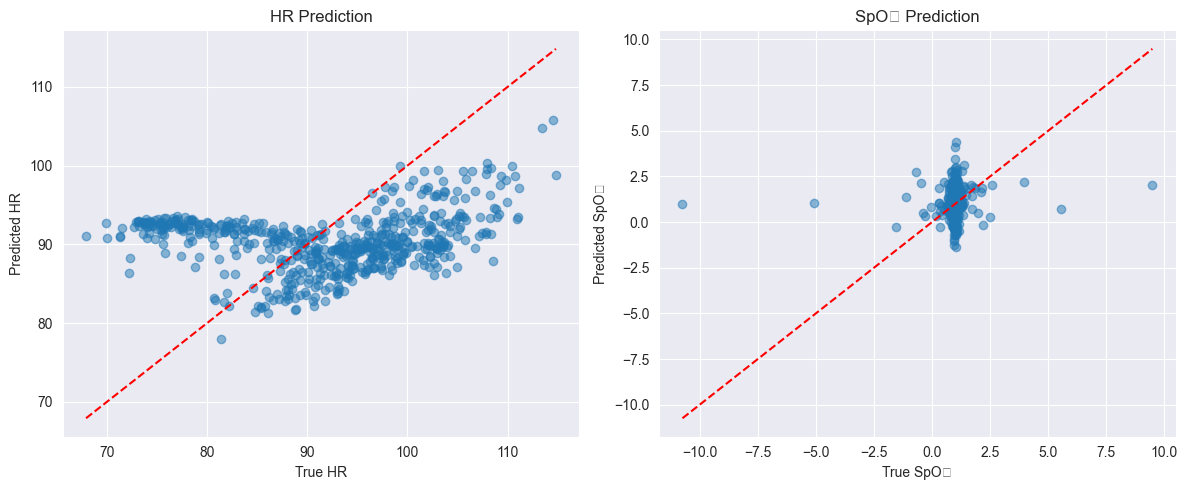

In [36]:
# Cell 11: Visualization
plt.figure(figsize=(12,5))

# HR
plt.subplot(1,2,1)
plt.scatter(y_test['hr_bpm'], y_pred[:,0], alpha=0.5)
plt.plot(
    [y_test['hr_bpm'].min(), y_test['hr_bpm'].max()],
    [y_test['hr_bpm'].min(), y_test['hr_bpm'].max()],
    'r--'
)
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("HR Prediction")

# SpO₂
plt.subplot(1,2,2)
plt.scatter(y_test['R_ratio'], y_pred[:,1], alpha=0.5)
plt.plot(
    [y_test['R_ratio'].min(), y_test['R_ratio'].max()],
    [y_test['R_ratio'].min(), y_test['R_ratio'].max()],
    'r--'
)
plt.xlabel("True SpO₂")
plt.ylabel("Predicted SpO₂")
plt.title("SpO₂ Prediction")

plt.tight_layout()
plt.show()



In [38]:
# Cell 12: Save model and scalers
os.makedirs("models", exist_ok=True)

joblib.dump(mlp, "models/physio_mlp.pkl")
joblib.dump(scaler_X, "models/physio_scaler_X.pkl")
joblib.dump(scaler_y, "models/physio_scaler_y.pkl")

print("Physiological MLP model and scalers saved successfully!")



Physiological MLP model and scalers saved successfully!
